---
## &nbsp;&nbsp;1η Άσκηση  -  Τεχνικές Εξόρυξης Δεδομένων - Εαρινό Εξάμηνο 2020-2021

* Φαραώ Γεώργιος&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- &nbsp;&nbsp;sdi1700177
* Ροβιθάκης Ιωάννης &nbsp; -&nbsp;&nbsp; sdi1800164
---

# Preparations

In [2]:
# Mount the google drive to have access to the files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Import some of the libraries we will need
import re
import sys
import time
import math
import nltk
import heapq
import pickle
import os.path
import datetime
import numpy as np
import pandas as pd
from nltk.stem import *
from numpy import random
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from scipy.sparse import csr_matrix
from collections import OrderedDict
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import hamming
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('stopwords')
%matplotlib inline 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Read the input file and create a dataframe
Location = r'/content/gdrive/MyDrive/DataMining2021/HW1/netflix_titles.csv'
df=pd.read_csv(Location)
df.tail(1)

show_id  ...                                        description
7786   s7787  ...  This documentary delves into the mystique behi...

[1 rows x 12 columns]

In [5]:
# Ensure that all the primary keys of the dataframe are unique
df['show_id'].describe()

count      7787
unique     7787
top       s4698
freq          1
Name: show_id, dtype: object

In [6]:
#df['duration'].isnull().unique()

# Some Functions Used


In [7]:
# A function that breaks the given dictionary into two lists (keys : data)
# to allow easier plotting
def break_dict(d):
  keys = []
  data = []
  for key in d:
    keys.append(key)
    data.append(d[key])
  return (keys, data)

In [8]:
# A function that returns the sum of the data on a given dictionary
def dict_sum(d):
  return sum(d.values())

In [9]:
# A Function that transforms a 1D index into a 2D index for given matrix dimentions
def transform2D(index, columns):
  return (index//columns, index%columns)

In [10]:
# A function that plots the data of the given dict on the 2D grid position pointed by the given index
keep_top = 5 # USER variable = change for more/less values printed
def plot_next(fig, country, pdict, row, col, idx):
  # Break the dict down 
  keys, data = break_dict(pdict)
  keys = shorten(keys, keep_top)
  data = shorten(data, keep_top)

  # Plot the subplot
  ax = fig.add_subplot(row, col, idx)
  ax.title.set_text(country)
  ax.pie(data, labels=keys, autopct='%1.1f%%', shadow=False, startangle=90)
  #ax.margins(x=0, y=-0.03)
  ax.axis('equal')

In [11]:
# A Function that returns only the first n elements of the given list
def shorten(lst, n):
  short = []
  i = 0
  for item in lst:
    if i == n:
      return short
    short.append(item)
    i+=1
  return short

In [12]:
# A function that turns a 'df string list' into a list of words by removing whitespaces 
# and spliting on the commas
def tolist(pseudolist):
  return pseudolist.replace(' ','').split(',')

In [13]:
# A function that returns the current yearas an int
def getCurrentYear():
  return datetime.datetime.now().year

In [14]:
# A function that based on the current year and the amount of years we need, 
# returns a list of the 'n' most recent years
def getYears(current_year, year_count):
  years = []
  for i in range(year_count):
    years.append( current_year-i )
  return years

In [15]:
# A function to make pie plots simpler
def pieplot(tags, data, title):
  fig1, ax1 = plt.subplots()
  ax1.pie(data, labels=tags, autopct='%1.1f%%', shadow=False, startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.title(title)
  plt.show()

In [16]:
def print_dict(trg):
  i=0
  for rec in trg:
    print(i, rec, trg[rec])
    i+=1

# **Ερώτημα 1:**
**Ποιό είδος υπερτερεί, οι ταινίες ή οι σειρές ;**

TV Shows: 2410
Movies: 5377

Οι ταινίες υπερτερούν.



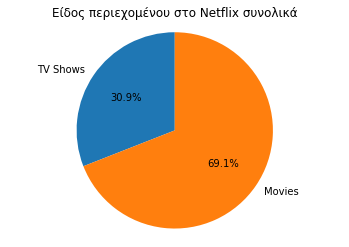

In [17]:
#First we find all the TV shows
series_list=df['type'][df['type']=='TV Show']
print("TV Shows:", len(series_list))

#Now we find all the movies
movies_list=df['type'][df['type']=='Movie']
print("Movies:", len(movies_list))

if len(series_list)>len(movies_list):
  print("\nΟι σειρές υπερτερούν.\n")
else:
  print("\nΟι ταινίες υπερτερούν.\n")

#Make a plot for visual interprentation  
categ = ['TV Shows', 'Movies']
vals=[len(series_list),len(movies_list)]
pieplot(categ, vals, 'Είδος περιεχομένου στο Netflix συνολικά')

Βλέπουμε ότι συνολικά, το Netflix έχει περισσότερες ταινίες κατα πολύ

# **Ερώτημα 2:**
**Τα τελευταία χρόνια το netflix επενδύει περισσότερο σε ταινίες ή σε σειρές;**

Μια πρώτη ιδέα, είναι να συγκρίνουμε το συνολικό άθροισμα των ταινιών ενάντια σε αυτό των σειρών, τα τελευταία **n** χρόνια (μπορεί να οδηγήσει σε ανακριβή αποτελέσματα άμα επιλέξουμε μεγάλο **n** ή εαν οι τάσεις μεταβάλλονται συνεχώς και πολύ απότομα)

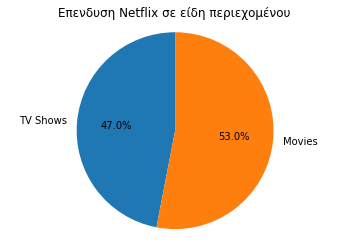


Το Netflix φαίνεται να επενδύει περισσότερο σε Ταινίες



In [18]:
# Get the current year
year = getCurrentYear()

# Define how many years in the past to check 
recent_years = 3 # <<< Feel free to play with this value

# Get a list with the years we will check based on the given 'recent_years' value
years = getYears(year, recent_years)

# For each one of these years, add all of its movies and tv shows on their 
# corresponding list to count and compare later on
recent_movies = []
recent_shows = []
for year in years:
  recent_movies = recent_movies + list(df['show_id'][ (df['type']=='Movie') & (df['release_year']==year)])
  recent_shows = recent_shows + list(df['show_id'][ (df['type']=='TV Show') & (df['release_year']==year)])

# And plot the results
categ = ['TV Shows', 'Movies']
vals=[len(recent_shows),len(recent_movies)]
pieplot(categ, vals, "Επενδυση Netflix σε είδη περιεχομένου")

# Compare the results
print()
if len(recent_shows)>len(recent_movies):
  print("Το Netflix φαίνεται να επενδύει περισσότερο σε Σειρές")
else:
  print("Το Netflix φαίνεται να επενδύει περισσότερο σε Ταινίες")
print()

Μια άλλη μετρική (αρκετά πιο ακριβής - αξιόπιστη), είναι να συγκρίνουμε τις τάσεις προσθεσης ταινιών-σειρών στο Netflix ανα χρονιά

In [19]:
# Get the current year
year = getCurrentYear()

# Start from the first "completed year" to have more accurate results since the
# current year is still going and its data is not final
# (here we could use a machine learning model to try and guess the trend of this
# year based on the past years history)
year = year - 1

# Define how many years in the past to check 
recent_years = 10 # <<< Here we can actually use a much larger amount of years

# Get a list with the years we will check based on the given 'recent_years' value
years = getYears(year, recent_years)

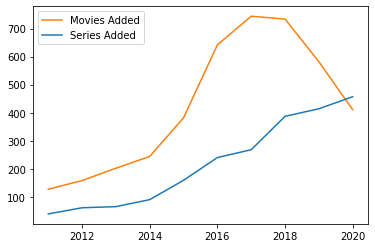

In [20]:
# For each one of these years, count the amounts of both new movies and new series added on Netflix
movie_additions = dict()
show_additions = dict()
for year in years:
  movie_additions[year] = len(df['show_id'][ (df['type']=='Movie') & (df['release_year']==year)])
  show_additions[year] = len(df['show_id'][ (df['type']=='TV Show') & (df['release_year']==year)])

# Break down the dictionaries
myear, mcount = break_dict(movie_additions)
syear, scount = break_dict(show_additions)

# Plot the resulting trends to compare them
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(myear, mcount, color='tab:orange', label='Movies Added')
ax.plot(syear, scount, color='tab:blue', label='Series Added')
ax.legend()
plt.show()

Με την μετρική αυτή, βλέπουμε ότι ενώ ιστορικά οι ταινίες υπερισχύουν, τα τελευταία χρόνια βλέπουμε σημαντική μείωση στο πλήθος τους, με αποτέλεσμα η σταθερή αύξηση στο πλήθος των σειρών τελικά να υπερισχύει

# **Ερώτημα 3:**
**Ποιά χώρα έχει το περισσότερο περιεχόμενο;**

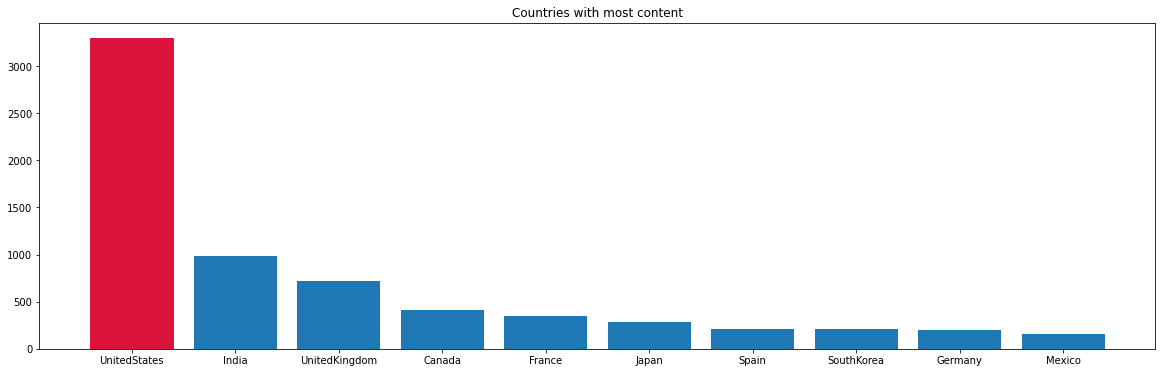


Country with the most content is: UnitedStates with 3297 movies and shows


In [21]:
countries=dict()

#first we get the column with all the countries
new_col = df['country'].dropna()

#Now we count the content of each country
for element1 in new_col:
  clist=element1
  parts=[]
  parts = clist.split(",")
 
  for element2 in parts:
    element2=element2.replace(' ','')
    if element2 not in countries:
      countries[element2]=1
    else:
      countries[element2]+=1

from collections import OrderedDict
from operator import itemgetter
#These 2 lines order the countries dictionary and find the top 10 items
new_dict=OrderedDict(sorted(countries.items(), key = itemgetter(1), reverse = True))
res=list(new_dict.items())[:10]

x=[]
y=[]
for entry in res:
  x.append(entry[0])
  y.append(entry[1])

#Plot that shows top-10 countries with the most content
fig = plt.figure(figsize=(20, 6))
categ = x
vals=y

barlist=plt.bar(categ,vals)
plt.title('Countries with most content')
barlist[0].set_color('crimson')
plt.show()

print("\nCountry with the most content is: %s with %d movies and shows" % res[0])

Οπως περιμέναμε, η μεγαλύτερη αγορά του Netflix είναι η Αμερική με μεγάλη διαφορα. Ενδιαφέρον είναι το γεγονός ότι δεύτερη έρχεται η Ινδία, μια αγορά που ανεβαίνει ταχύτατα τα τελευταία χρόνια σε αρκετούς τομεις.

# **Ερώτημα 4:**
**Τι είδους περιεχόμενο έχει κάθε χώρα;**


Για κάθε μια από τις χώρες, θα βρούμε τα είδη / κατηγορίες περιεχομένου που υπάρχουν και σε τι βαθμό υπάρχουν και θα τυπώσουμε τις **n** που υπερισχύουν:

In [22]:
# We will print the top n amount of categories per country
n = 5

In [23]:
# Check for missing data
print(df['country'].isnull().unique())
print(df['listed_in'].isnull().unique())

[False  True]
[False]


Λείπουν κάποιες τιμές που αντιστοιχούν σε χώρες, αλλά δεν λείπει καμία τιμή από τις κατηγορίες. Συνεπώς για το dataset αυτο αρκεί να αγνοήσουμε τις εγγραφές με κενές χώρες

In [24]:
df4 = df.loc[ df['country'].isnull()==False ]
#df4.tail(1)

In [25]:
# A function that given an 'external' dictionary and two lists of elements, updates
# the 'internal' dictionaries counters
def update(external, countries, listed):
  for country in countries:
    if country == '': # Ignore missing values
      continue
    if country not in external:
      external[country] = dict()
      for category in listed:
        external[country][category] = 1
    else:
      for category in listed:
        if category not in external[country]:
          external[country][category] = 1
        else:
          external[country][category] += 1
  return external

In [26]:
# Data calculation phase : based on the dataset count the required results
count_dict = dict()
# For each record (movie/show)
for index, record in df4.iterrows():
  # Get the countries it is available to
  countries = tolist(record['country'])
  
  # Get the categories it is listed in
  listed = tolist(record['listed_in'])

  # Use these lists to update the dictionary that holds the counters
  count_dict = update(count_dict, countries, listed)

In [27]:
# Sort the internal dictionaries of 'count_dict' to find the 'top n' categories for each country
for index, country in enumerate(count_dict):
  sorted_tuples = sorted(count_dict[country].items(), key=lambda item: item[1], reverse=True)
  sorted_dict = OrderedDict()
  for cat, cnt in sorted_tuples:
      sorted_dict[cat] = cnt
  count_dict[country] = sorted_dict

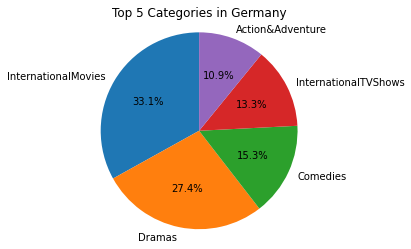

In [28]:
# Test if the data was handled correctly and we have the expected results
count_dict['Germany']
keys, data = break_dict(count_dict['Germany'])
keys = shorten(keys, 5)
data = shorten(data, 5)
pieplot(keys, data, "Top 5 Categories in Germany")

 We have usable data for 117 countries:



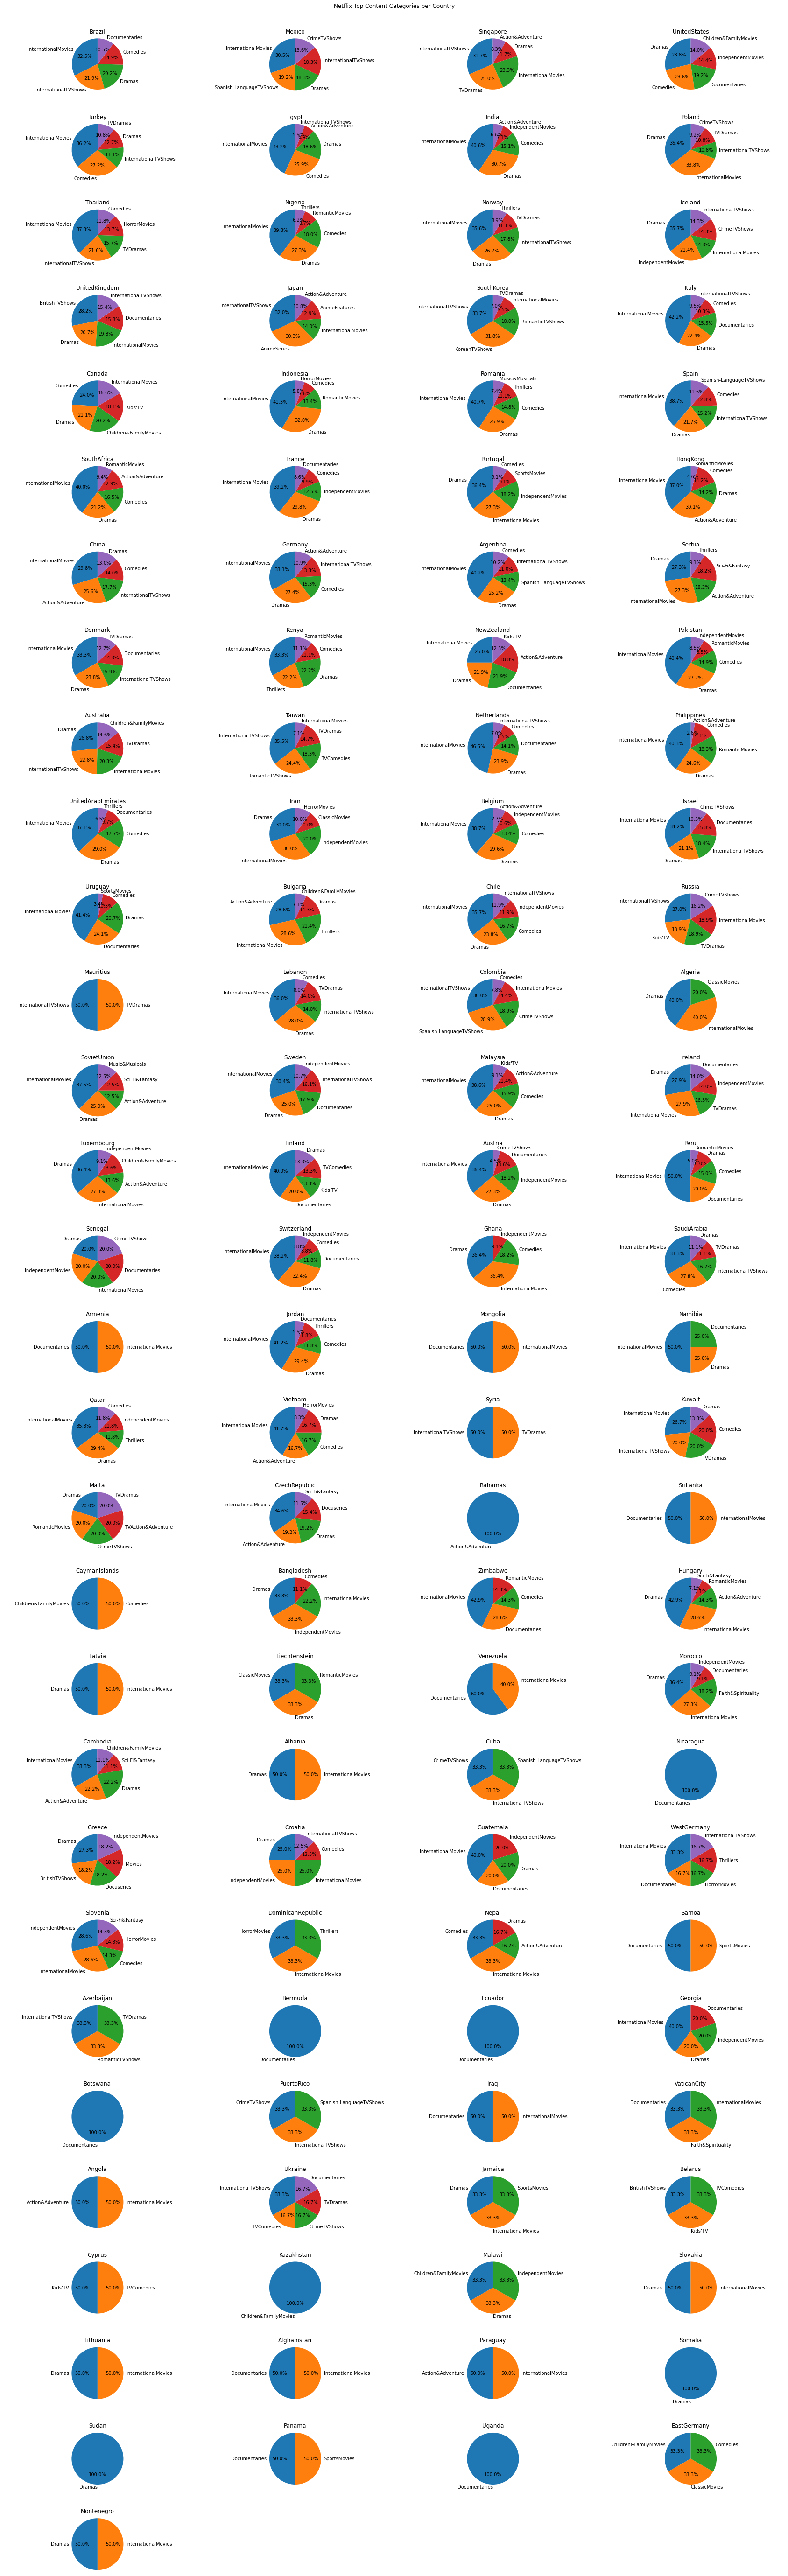

In [29]:
# For each country, plot the results:
# All plotted in a grid for better readability
print( " We have usable data for %d countries:\n" % len(count_dict))
# Calculate the total dimentions based on the required amount of columns
cols = 4
rows = math.ceil(len(count_dict)/cols)

fig = plt.figure(figsize=(30,100))
plt.subplots_adjust(wspace=0.05, hspace=0.5)
plt.title("Netflix Top Content Categories per Country", y=1.01)
plt.axis('off')

i = 1
for country in count_dict:
  plot_next(fig, country, count_dict[country], rows, cols, i)
  i += 1

plt.show()

Ενδιαφέροντα αποτελέσματα για την μελέτη των συνηθειών και των προτιμήσεων των πελατών της εταιρείας σε κάθε χώρα. Πολύ χρήσιμα για αποφάσεις παραγωγής στοχευμένου περιεχόμενου για μια χώρα. Στις χώρες στις οποίες έχουμε λιγότερες των 5 κατηγορίες να εμφανίζονται, προφανώς δεν υπάρχουν αρκετά δεδομένα στο dataset μας και τα αποτελέσματα πιθανον να μην ειναι ακριβή και αντιπροσωπευτικά. Ενδιαφέρουσα θα ήταν η ίδια μελέτη για διαφορετικές χρονιές για να δούμε πως μεταβάλλονται οι προτιμήσεις των πελατών κάθε χώρας, σύμφωνα με τις τάσεις της αγοράς.

# **Ερώτημα 5:** 
**Ποιοι ηθοποιοί παίζουν στις περισσότερες ταινίες και αντίστοιχα σειρές σε κάθε χώρα;**

In [30]:
# A Function that returns only the first n elements of the given list
def shorten(lst, n):
  short = []
  i = 0
  for item in lst:
    if i == n:
      return short
    short.append(item)
    i+=1
  return short

# A function that breaks the given dictionary into two lists (keys : data)
# to allow easier plotting
def break_dict(d):
  keys = []
  data = []
  for key in d:
    keys.append(key)
    data.append(d[key])
  return (keys, data)

# A function that plots the data of the given dict on the 2D grid position pointed by the given index
keep_top = 5 # USER variable = change for more/less values printed
def plot_next(fig, country, pdict, row, col, idx):
  # Break the dict down 
  keys, data = break_dict(pdict)
  keys = shorten(keys, keep_top)
  data = shorten(data, keep_top)

  # Plot the subplot
  ax = fig.add_subplot(row, col, idx)
  ax.title.set_text(country)
  ax.pie(data, labels=keys, autopct='%1.1f%%', shadow=False, startangle=90)
  ax.axis('equal')

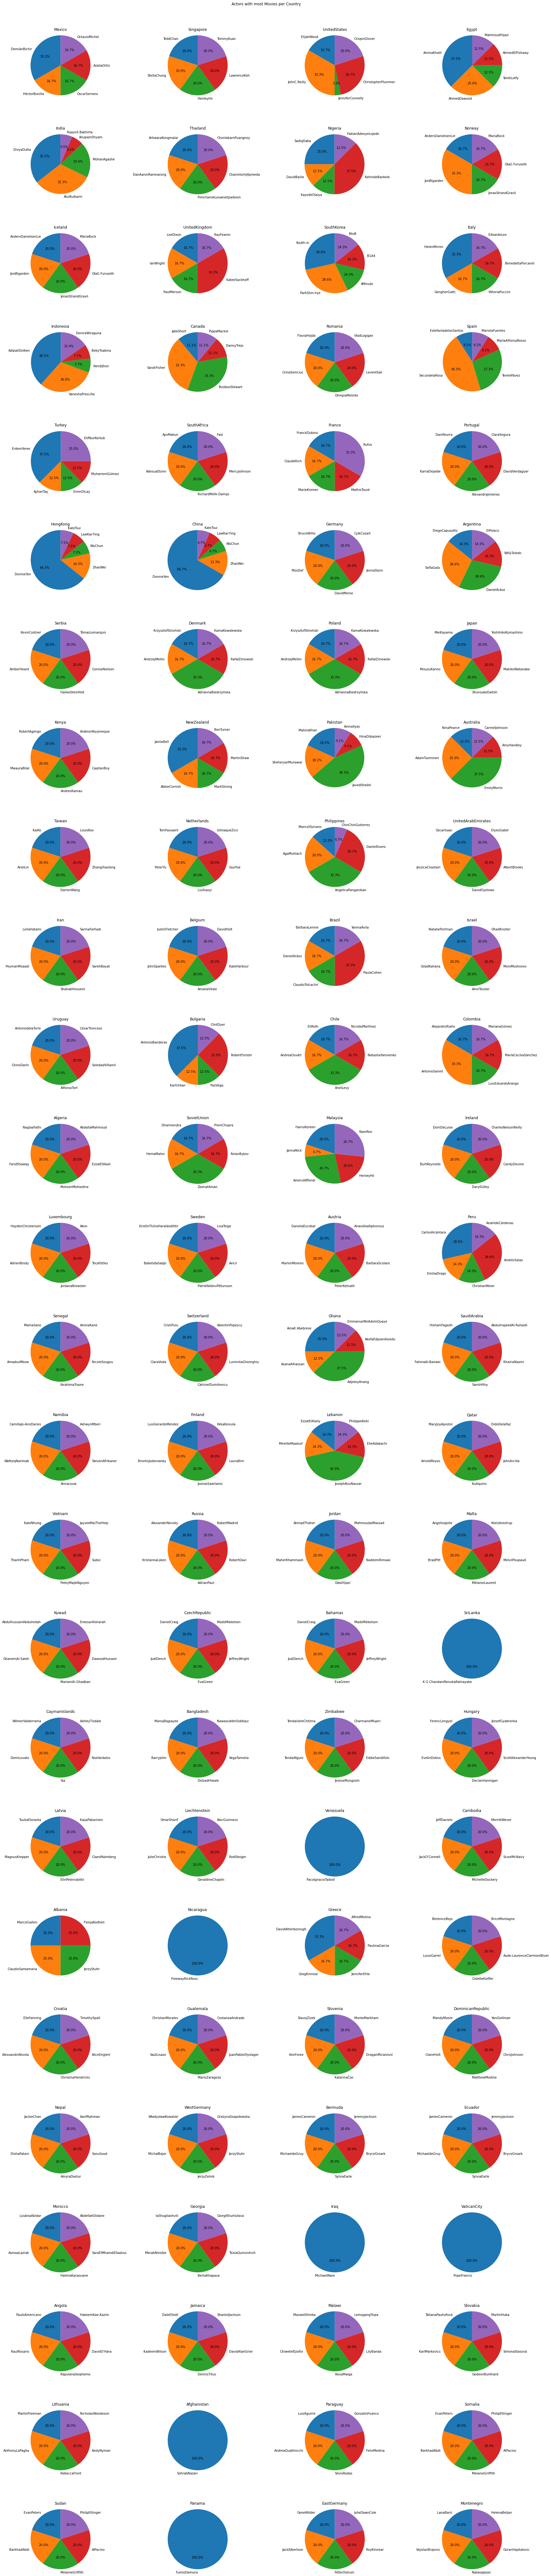

In [31]:
import math
countries_list=[]

#Get cast and countries on which there are movies
new_count=df[['cast','country']][df['type']=='Movie'].dropna()
count_col=new_count['country'].dropna()

#We create a list with all the countries that have movies
for element1 in count_col:
  clist=element1
  parts=[]
  parts = clist.split(",")
 
  for element2 in parts:
    element2=element2.replace(' ','')
    if element2 not in countries_list:
      countries_list.append(element2)

countries_list=list(dict.fromkeys(countries_list))
clean_list=[]
actor_movies=dict()

for i in countries_list:
  j = i.replace(' ','')
  clean_list.append(j)
countries_list=list(dict.fromkeys(clean_list))

i=0
full_dict=dict()
for cnt in countries_list:      #We traverse the list of countries
  temp_dict=dict()              #For each country we create a dictionary with keys all the actors that have taken part in a movie of the given country
                                # and values the number of the actor's movies in the country
  for element1 in new_count.index:    #Traverse each row of the dataframe
    clist1=new_count['country'][element1]
    parts1=[]
    parts1 = clist1.split(",")
    new_parts1=[]
    for member in parts1:             #remove redundant spaces
      new_mem=member.replace(' ','')
      new_parts1.append(new_mem)
    if cnt in new_parts1:           #If country "cnt" is in new_parts1 we find the actors
      new_col=new_count['cast'][element1]        
      parts=[]
      parts = new_col.split(",")
      new_parts=[]
      for member in parts:
        new_mem=member.replace(' ','')
        new_parts.append(new_mem)
      for element2 in new_parts:       #We add each actor in country's dictionary or if he/she already is in the dict we increase the value            
        if element2 not in temp_dict:
          temp_dict[element2]=1
        else:
          temp_dict[element2]= temp_dict[element2] + 1

  #Now we find the actors with the top-5 values
  new_dict=OrderedDict(sorted(temp_dict.items(), key = itemgetter(1), reverse = True))
  full_dict[cnt]=temp_dict

  i=i+1


cols = 4
rows = math.ceil(len(full_dict)/cols)

fig = plt.figure(figsize=(30,150))
plt.subplots_adjust(wspace=0.25, hspace=0.5)
plt.title("Actors with most Movies per Country", y=1.01)
plt.axis('off')

i = 1
for country in full_dict:
  plot_next(fig, country, full_dict[country], rows, cols, i)
  i += 1

plt.show()

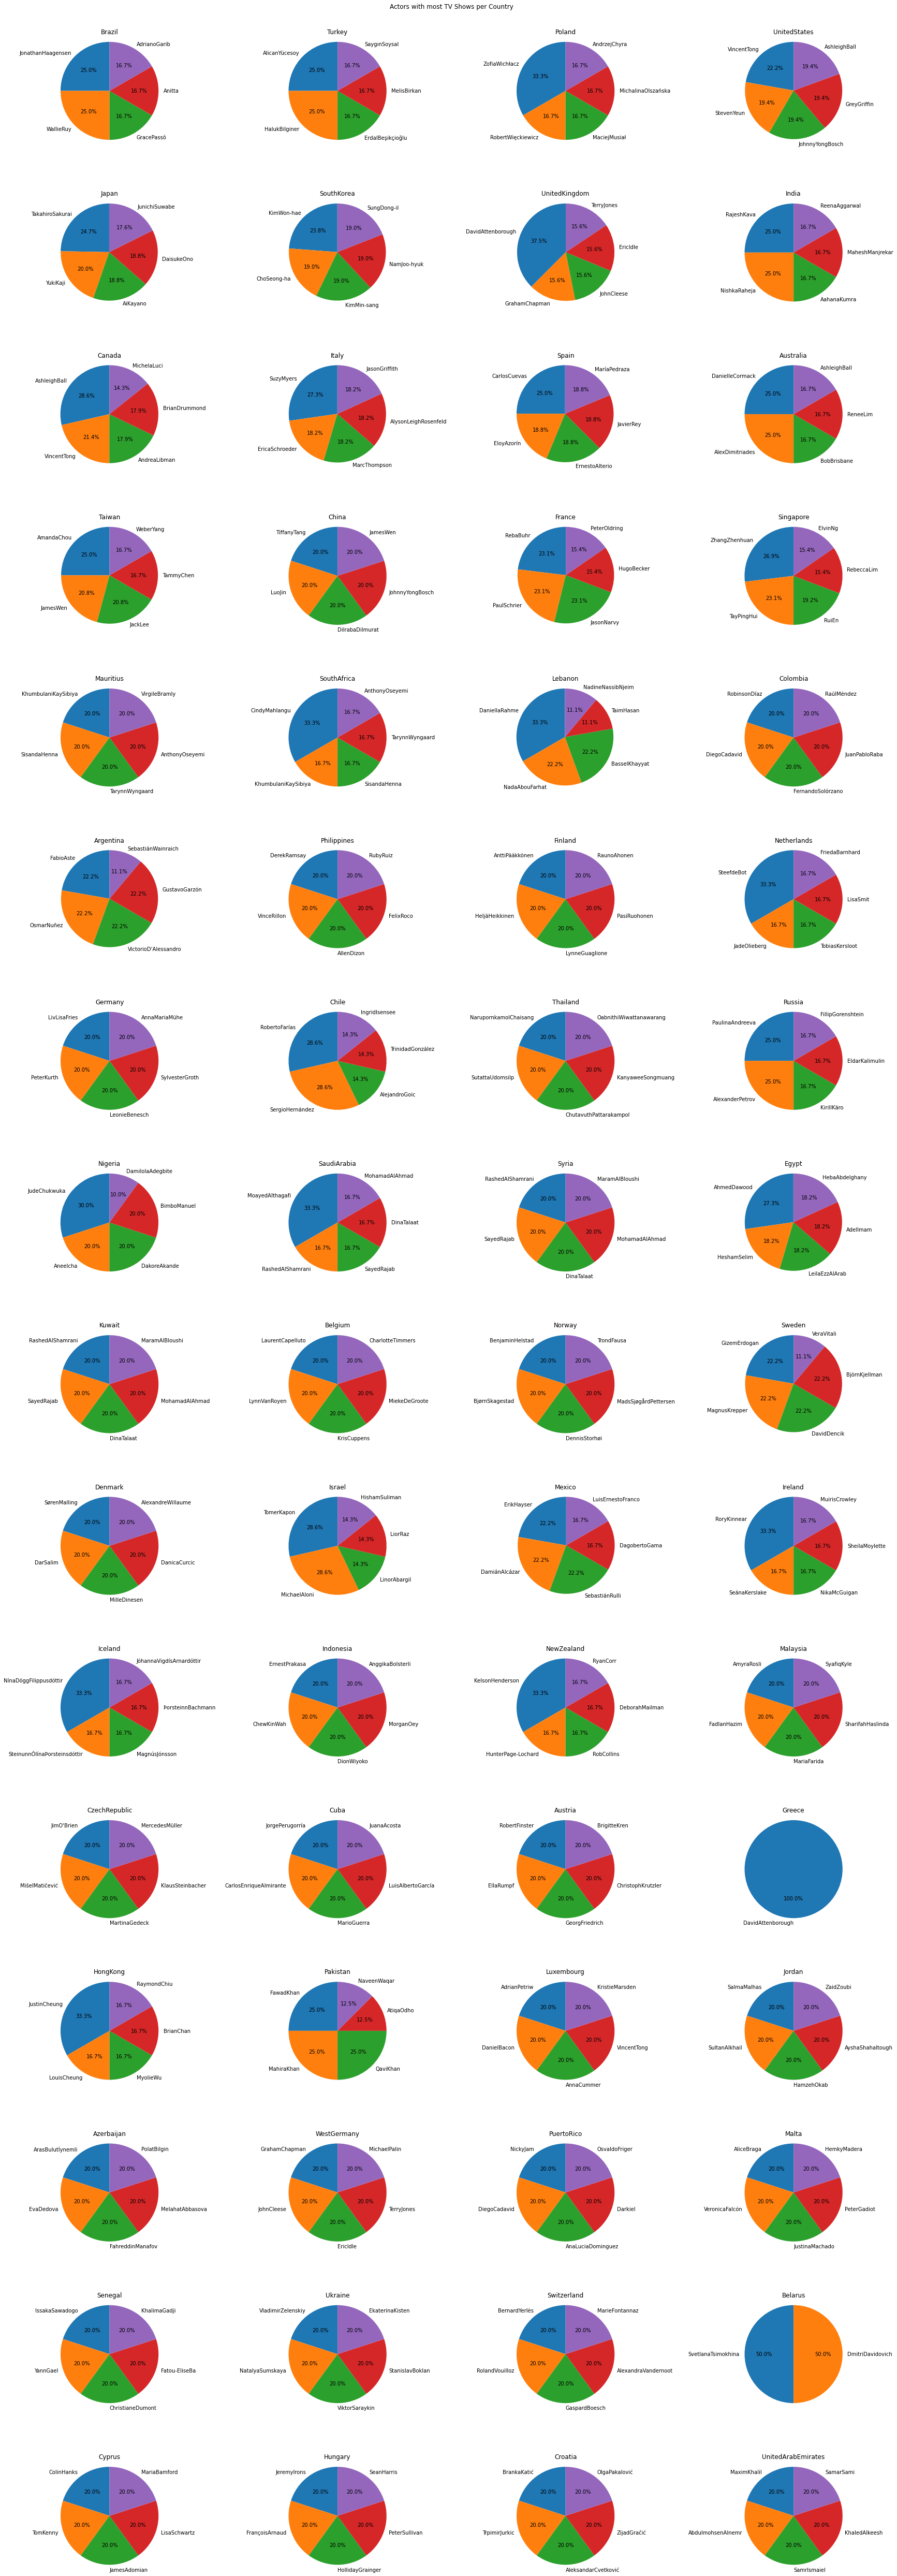

In [32]:

countries_list=[]

#Get cast and countries on which there are tv shows
new_count=df[['cast','country']][df['type']=='TV Show'].dropna()
count_col=new_count['country'].dropna()

#We create a list with all the countries that have tv shows
for element1 in count_col:
  clist=element1
  parts=[]
  parts = clist.split(",")
 
  for element2 in parts:
    element2=element2.replace(' ','')
    if element2 not in countries_list:
      countries_list.append(element2)

countries_list=list(dict.fromkeys(countries_list))
clean_list=[]
actor_movies=dict()

for i in countries_list:
  j = i.replace(' ','')
  clean_list.append(j)
countries_list=list(dict.fromkeys(clean_list))

i=0
full_dict=dict()
for cnt in countries_list:      #We traverse the list of countries
  temp_dict=dict()              #For each country we create a dictionary with keys all the actors that have taken part in a tv show of the given country
                                # and values the number of the actor's tv shows in the country
  for element1 in new_count.index:    #Traverse each row of the dataframe
    clist1=new_count['country'][element1]
    parts1=[]
    parts1 = clist1.split(",")
    new_parts1=[]
    for member in parts1:             #remove redundant spaces
      new_mem=member.replace(' ','')
      new_parts1.append(new_mem)
    if cnt in new_parts1:           #If country "cnt" is in new_parts1 we find the actors
      new_col=new_count['cast'][element1]        
      parts=[]
      parts = new_col.split(",")
      new_parts=[]
      for member in parts:
        new_mem=member.replace(' ','')
        new_parts.append(new_mem)
      for element2 in new_parts:       #We add each actor in country's dictionary or if he/she already is in the dict we increase the value            
        if element2 not in temp_dict:
          temp_dict[element2]=1
        else:
          temp_dict[element2]= temp_dict[element2] + 1

  #Now we find the actors with the top-5 values
  new_dict=OrderedDict(sorted(temp_dict.items(), key = itemgetter(1), reverse = True))
  full_dict[cnt]=new_dict

  i=i+1

cols = 4
rows = math.ceil(len(full_dict)/cols)

fig = plt.figure(figsize=(30,90))
plt.subplots_adjust(wspace=0.25, hspace=0.5)
plt.title("Actors with most TV Shows per Country", y=1.01)
plt.axis('off')

i = 1
for country in full_dict:
  plot_next(fig, country, full_dict[country], rows, cols, i)
  i += 1

plt.show()


Από  τα παραπάνω αποτελέσματα, μπορούμε να βγάλουμε συμπεράσματα όσον αφορά τους πιο διάσημους/αγαπημένους/αναγνωρίσιμους ηθοποιούς κάθε χώρας, πληροφορία ιδιαίτερα πολύτιμη για διαφημιστικές εταιρείες που θέλουν να προωθήσουν προϊόντα μέσω ηθοποιών. Ενδιαφέρον θα ήταν να βλέπαμε μια παρόμοια αναπαράσταση που να δείχνει επίσης και τις ηλικιακές ομάδες που προτιμούν σειρές/ταινιες του κάθε ηθοποιού για να γίνει ακόμα πιο στοχευμένη η διαφήμιση.

# **Ερώτημα 6:**
**Παρέχει το Netflix πλούσιο περιεχόμενο για όλες τις ηλικίες;** 

Με βάση τα ratings θα δούμε πως χωρίζεται το περιεχόμενο μεταξύ των τεσσάρων ηλικιακών κλάσεων, μετρώντας τα:

In [33]:
# The age group ratings we have available, any rating not belonging in one of
# these groups will be ignored | Stored in sets for O(1)
lset = {"G", "TV-Y", "TV-G"}
oset = {"PG", "TV-Y7", "TV-Y7-FV", "TV-PG"}
tset = {"PG-13", "TV-14"}
mset = {"R", "NC-17", "TV-MA"}

# A dict to store them all
age_groups = { "Little Kids":lset, "Older Kids":oset, "Teens":tset, "Mature":mset}

# A function that gets the rating of a movie or a show as a string, and returns
# the age group it belongs to (Little Kids, Older Kids, Teens, Mature). 
# Works with a variety of age rating formats
def get_age_group(rating):
  for group in age_groups:
    if rating in age_groups[group]:
      return group
  return None # No group if it was not found

In [34]:
# A function that given a list of movie/show ratings, returns a dictionary that
# breaks the ratings into 4 basic rating groups
def group_ratings(rating_list):
  # Count each valid rating in the list as part of one of the groups
  group_count = dict()
  for rating in rating_list:
    rat = get_age_group(rating)
    # Ignore invalid/unknown ratings
    if rat == None:
      continue
    if rat not in group_count:
      group_count[rat] = 1
    else:
      group_count[rat] += 1
  return group_count

In [35]:
# Function that given a list of integers, turns them into percentages
def percent(data_list):
  # Get the total amount of valid movie ratings
  total = sum(data_list)
  for i, item in enumerate(data_list):
    data_list[i] = item/total
  return data_list

In [36]:
# Check for missing values on our dataset in the columns that we will work on
df['rating'].isnull().unique()
# We found records that have no rating so we will need to ignore them on our calculations

array([False,  True])

 **Ταινίες ανα ηλικιακή ομάδα:**

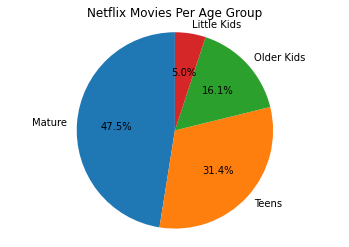

Mature  Teens  Older Kids  Little Kids
0    2511   1658         852          267

In [37]:
# Get a list of all the movies with ratings (Only need their ratings here)
rating_list = list(df['rating'][(df['type']=='Movie') & (df['rating'].isnull()==False)])

# Break the ratings into groups
results = group_ratings(rating_list)

# Break the dict into lists for plotting
keys, data = break_dict(results)

# Plot the results
pieplot(keys, data, "Netflix Movies Per Age Group")

# Print the analytics in a clear way
dfp = pd.DataFrame(results, index=[0])
dfp

**Σειρές ανα ηλικιακή ομάδα:**

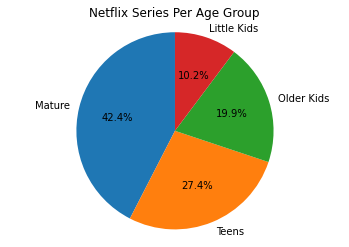

Mature  Teens  Older Kids  Little Kids
0    1020    659         478          246

In [38]:
# Get a list of all the series with ratings (Only need their ratings here)
rating_list = list(df['rating'][(df['type']=='TV Show') & (df['rating'].isnull()==False)])

# Break the ratings into groups
results = group_ratings(rating_list)

# Break the dict into lists for plotting
keys, data = break_dict(results)

# Plot the results
pieplot(keys, data, "Netflix Series Per Age Group")

# Print the analytics in a clear way
dfp = pd.DataFrame(results, index=[0])
dfp

Συμπέρασμα: Παρατηρούμε ότι σε γενικές γραμμές, το Netflix επενδύει κυρίως σε έφηβους και ενήλικες. Χονδρικά τα 3/4 του περιεχομένου του απευθύνονται σε αυτούς. Στις σειρές, το ποσοστό που απευθύνεται σε μικρά και μεγαλύτερα παιδιά αυξάνεται λίγο αλλά η γενική ιδέα φαίνεται να παραμένει η ίδια. <br/>
Τα αποτελέσματα είναι λογικά, καθώς οι ενήλικες και οι έφηβοι αποτελούν τις πιο απαιτητικές ομάδες χρηστών, οι οποίες αποφέρουν και σημαντικά μεγαλύτερα έσοδα στην πλατφόρμα

# **Ερώτημα 7:**
**Νέο περιεχόμενο στο Netflix ανα μήνα**

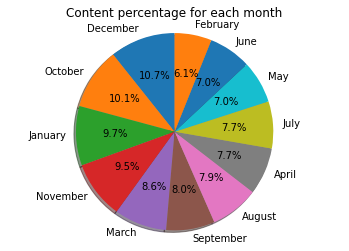

In [39]:
#First we get each month that content has been added
dates_added=df['date_added'].str.replace('\d+', '').str.replace(' ','').str.replace(',','').dropna()
months_list=list(dates_added)
months_dict=dict()

#Now we count how much content has been added each month
for month in months_list:
  if month not in months_dict:
    months_dict[month]=1
  else:
     months_dict[month]= months_dict[month]+1

#Sort the dictionary 
sort_dict=OrderedDict(sorted(months_dict.items(), key = itemgetter(1), reverse = True))

x=[]
y=[]
for indx in sort_dict:
  x.append(indx)
  y.append(months_dict[indx])
labels =x
sizes =y

#Make a plot
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
      shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Content percentage for each month')
plt.show()

Βλέπουμε ότι μακράν ο μήνας με το λιγότερο νέο περιεχόμενο, είναι ιστορικά ο Φεβρουάριος, ενώ ακολουθούν με μικρή απόσταση ο Μάιος και ο Ιούνιος. Άρα ο καλύτερος μήνας για τον παραγωγό της εκφώνησης θα ήταν ο Φεβρουάριος, καθώς όχι μονο έχει πολύ λίγες νέες ταινίες, αλλά ταυτόχρονα, σε αντίθεση με τον Μάιο και τον Ιούνιο, είναι χειμερινός μήνας, και ο κόσμος περνάει περισσότερο χρόνο μέσα στο σπίτι οπότε είναι και σχετικά πιο αυξημένη η "κατανάλωση" ταινιών και περιεχομένου.

# **Ερώτημα 8:**
**Συγκεντρωτική παρουσίαση των ειδών του περιεχομένου:**

Θα συγκεντρώσουμε σε μια λίστα την ένωση όλων των λιστών της στήλης listed_in   και στη συνέχεια θα μετρήσουμε πόσες φορές "εμφανίζεται" η κάθε κατηγορία, δηλαδή πόσες σειρές καλύπτουν την κάθε κατηγορία. Το γράφημα - συμπέρασμα που ζητείται είναι συγκεντρωτικό, οπότε θα μαζέψουμε τις πληροφορίες για ταινίες και σειρές μαζί.

In [40]:
# First we check if we have any missing values
df['listed_in'].isnull().unique()
# No missing values, no need to handle anything

array([False])

In [41]:
# We get a dataframe with all the categories
categories = []
for item in df['listed_in']:
  categories += item.replace(' ','').split(',')

# Count the times each category appears
cate_count = dict()
for item in categories:
  if item not in cate_count:
    cate_count[item] = 1
  else:
    cate_count[item] += 1

In [42]:
# We will turn the dict into an ordered dict for a better visualization

# Sort the dict and turn it into a list of sorted tuples
sorted_tuples = sorted(cate_count.items(), key=lambda item: item[1])

# Turn the sorted tuple list into an ordered dict
sorted_dict = OrderedDict()
for cat, cnt in sorted_tuples:
    sorted_dict[cat] = cnt

cate_count = sorted_dict

In [43]:
# Function that returns an array of random unique number
# Used in pie plot to guarantee unique colors
def unique_colors(amount):
  r = lambda: random.randint(0,255)
  uniques = set()
  i = 0
  while i < amount:
    new = '#{:02x}{:02x}{:02x}'.format(r(), r(), r())
    if new not in uniques:
      uniques.add(new)
      i += 1
  return list(uniques)

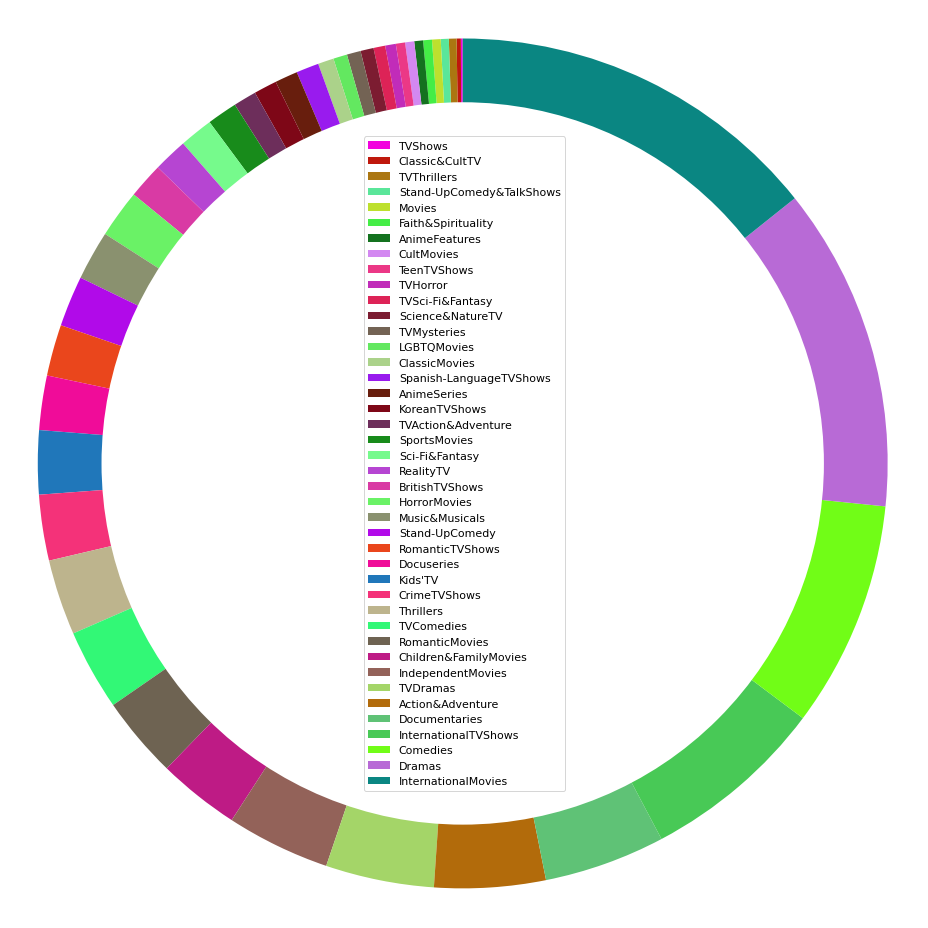


 Total amount of categories: 42



In [84]:
# Break the dict down
category, count = break_dict(cate_count)

# Plot the results ( This is the best way we could plot the results to make them readable)
plt.subplots(figsize=(13, 13))
#explode = np.ones(len(count)) * 0.05
col = unique_colors(len(category))
patches, texts = plt.pie(count, shadow=False, startangle=90, pctdistance=0.85, colors=col)
plt.legend(patches, category, loc="center", prop={'size': 11})
centre_circle = plt.Circle((0,0),0.85,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.tight_layout()
plt.show()

# We also print the total amount of categories
print("\n Total amount of categories: %d\n" % len(category))

Συμπεράσματα: Tο μισο περιεχόμενο ανοίκει - αποτελείται από 6 μόλις κατηγορίες. Άρα αν χωρίσουμε τους χρήστες σε υποτυπώδεις κλάσεις με βάση τις διαθέσιμες κατηγορίες περιεχομένου, γίνεται προφανές ότι παράγοντας μια ταινία ή σειρά σε μια από τις πιο δημοφιλείς κατηγορίες, καλύπτουμε τα ενδιαφέροντα και κατα συνέπεια μπορούμε να προσεγγίσουμε ενα τεράστιο ποσοστό των χρηστών της πλατφόρμας.

# **Ερώτημα 9:**
**Μελέτη των σκοινοθετών κάθε χώρας**

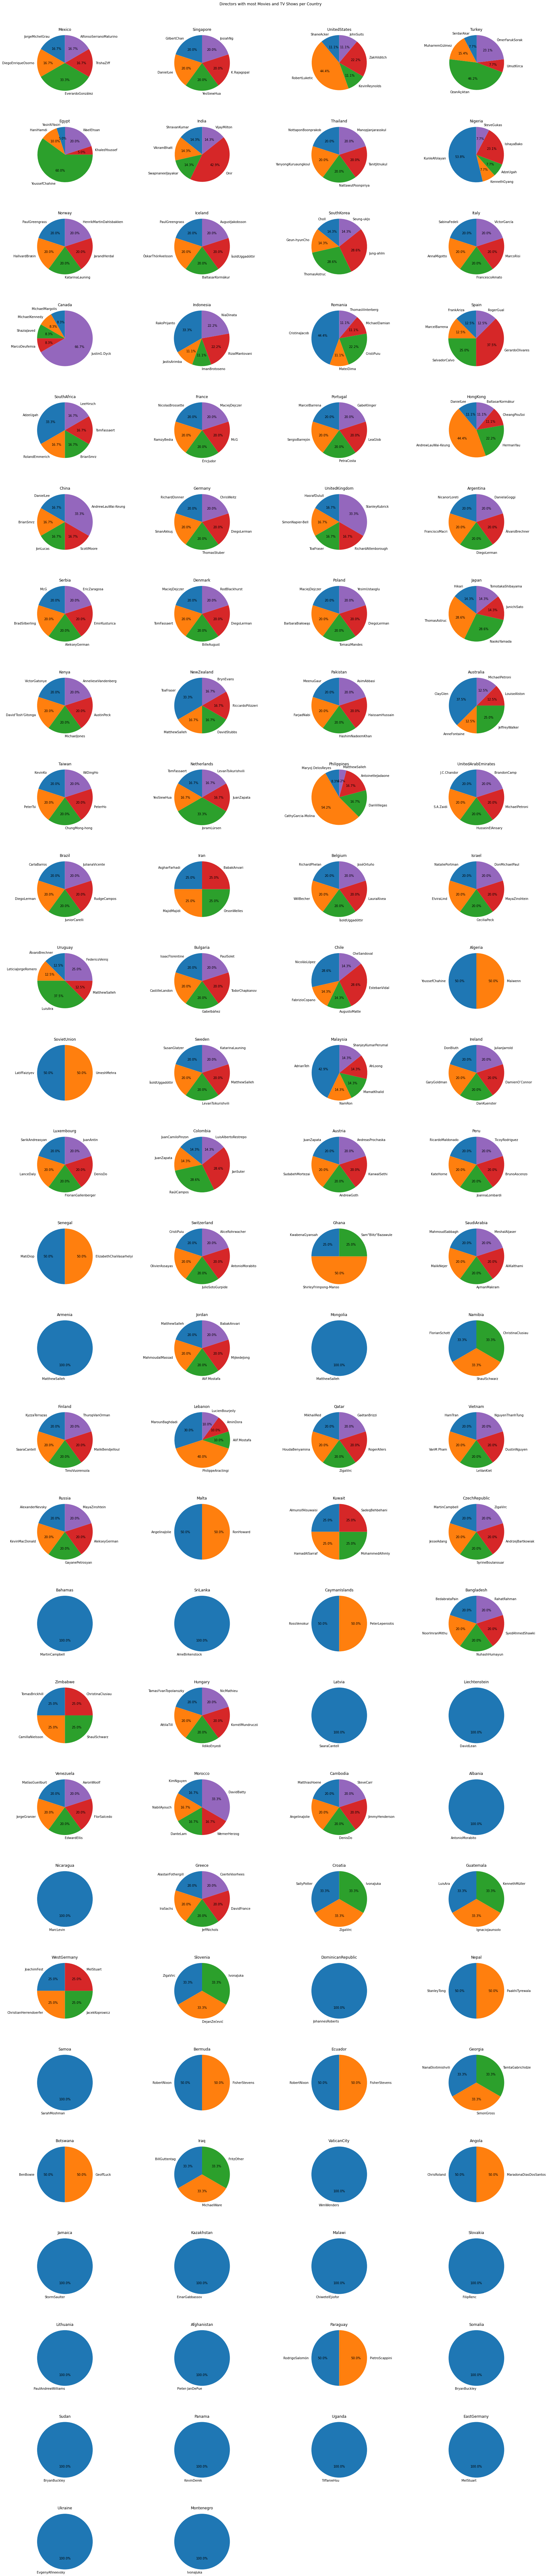

In [45]:
#First we create a list of all the countries
countries_list=[]
new_count=df[['director','country']].dropna()
count_col=new_count['country'].dropna()

for element1 in count_col:
  clist=element1
  parts=[]
  parts = clist.split(",")
 
  for element2 in parts:
    element2=element2.replace(' ','')
    if element2 not in countries_list:
      countries_list.append(element2)
countries_list=list(dict.fromkeys(countries_list))
clean_list=[]
actor_movies=dict()

for i in countries_list:
  j = i.replace(' ','')
  clean_list.append(j)
countries_list=list(dict.fromkeys(clean_list))

i=0
full_dict=dict()
#Now we find each country's directors and how many movies or tv shows they have been a part of
for cnt in countries_list:    #First we traverse through the list of countries
  if cnt=='':
    continue
  temp_dict=dict()
  for element1 in new_count.index:      #for each country in new_count
    clist1=new_count['country'][element1]
    parts1=[]
    parts1 = clist1.split(",")
    new_parts1=[]
    for member in parts1:     
      new_mem=member.replace(' ','')
      new_parts1.append(new_mem)
    if cnt in new_parts1:     #We check if the country is in the current entry's countries
      new_col=new_count['director'][element1]        
      parts=[]
      parts = new_col.split(",")
      new_parts=[]
      for member in parts:
        new_mem=member.replace(' ','')
        new_parts.append(new_mem)
      for element2 in new_parts:  #We search all the directors of the current entry
        #if the director isn't in the coutry's dict we insert him
        if element2 not in temp_dict:
          temp_dict[element2]=1
        else:                 #If he is we increase his value
          temp_dict[element2]= temp_dict[element2] + 1
  new_dict=OrderedDict(sorted(temp_dict.items(), key = itemgetter(1), reverse = True))
  full_dict[cnt]=temp_dict

#print each country's top 5 directors
cols = 4
rows = math.ceil(len(full_dict)/cols)

fig = plt.figure(figsize=(30,150))
plt.subplots_adjust(wspace=0.25, hspace=0.5)
plt.title("Directors with most Movies and TV Shows per Country", y=1.01)
plt.axis('off')

i = 1
for country in full_dict:
  plot_next(fig, country, full_dict[country], rows, cols, i)
  i += 1

plt.show()

Από τα παραπάνω μπορούμε να δούμε ποιοί σκηνοθέτες έχουν τις περισσότερες παραγωγές σε κάθε χώρα-αγορά, και σε κάποιο βαθμό πόσο δημοφιλείς είναι στην αγορά αυτή. Χρήσιμη πληροφορία για επιλογή σκηνοθετών για μικρές/ενχώριες παραγωγές. <br/> Μπορούμε όμως να την επεκτείνουμε σε παγκόσμιο επίπεδο:

In [46]:
# Merge two dictionaries by summing the colliding elements
def sum_merge(trg, ad):
  for rec in ad:
    if rec in trg:
      trg[rec] += ad[rec]
    else:
      trg[rec] = ad[rec]
  return trg

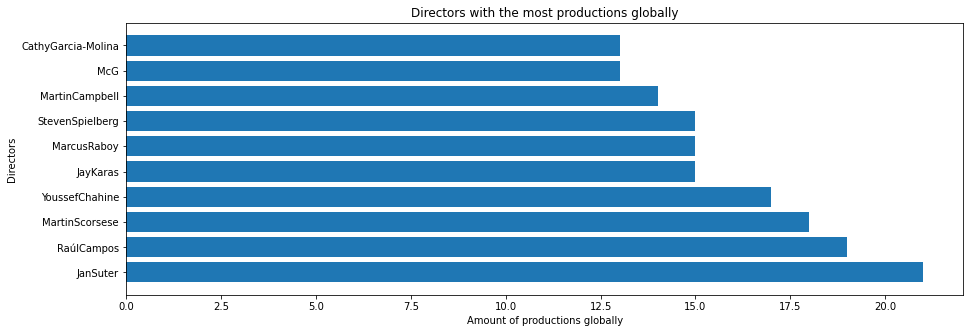

In [47]:
# Also collect all the directors globally and print the ones with the most total productions

# Create a dict that stores all the directors and their total amount of productions globaly
# by sum-merging the previous dicts created
all = dict()
for rec in full_dict.values():
  sum_merge(all, rec)

# Sort the total productions dict and pass the top 10 directors in lists to plot the
all=OrderedDict(sorted(all.items(), key = itemgetter(1), reverse = True))
out_names = []
out_vals  = []
for i, item in enumerate(all):
  if i == 10:
    break
  out_names.append(item)
  out_vals.append(all[item])

# Plot the final results
fig = plt.figure(figsize=(15,5))
plt.barh(out_names, out_vals)
plt.title('Directors with the most productions globally')
plt.xlabel("Amount of productions globally")
plt.ylabel("Directors")
plt.show()

Σαν επέκταση του προηγούμενου σχήματος, εδώ βλέπουμε τους σκηνοθέτες με τις περισσότερες συνολικά παραγωγές παγκοσμίως. Ενδιαφέρον δεδομένο αν συνδυαστεί με οικονομικά δεδομένα για παραγωγή μετρικών "απόδοσης" κάθε σκοινοθέτη όσον αφορά το μέσο κόστος ανα παραγωγή ή/και το μέσο κέρδος ανα παραγωγή. Με συνδυασμούς των μετρικών αυτών, μια παραγωγή μπορεί να επιλέξει σκηνοθέτη με βάση τόσο το ποσο δημοφιλής είναι όσο και την ιστορική του οικονομική απόδοση.

# **Ερώτημα 10:**
**Μελέτη των σειρών του Netflix σχετικά με το πλήθος των seasons τους:**

Θα μετρήσουμε πόσες σειρές ανοίκουν σε κάθε "κλάση" σεζόν:

In [48]:
# First we need to check if we have any missing values on our dataset
df['duration'].isnull().unique()
# Our dataset has no missing values so we don't need to handle such cases

array([False])

In [49]:
# Next we need to ensure that we have a 'Type' for all our records
df['type'].isnull().unique()
# Again no missing values, nothing to handle

array([False])

If we changed the dataset and introduced missing values, we would need to add more code to remove-ignore the records with the essential missing values from our calculations, but in our usecase and with our dataset everything is fine

In [50]:
# A key function for the season class sort later on
# Splits the given string and return its first part as an int to be used as a key
def custom_key(x):
  x = x[0]
  x = x.split()
  return int(x[0])

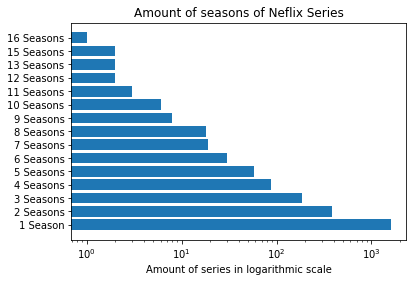


1 Season   - 1608
2 Seasons  - 382 
3 Seasons  - 184 
4 Seasons  - 87  
5 Seasons  - 58  
6 Seasons  - 30  
7 Seasons  - 19  
8 Seasons  - 18  
9 Seasons  - 8   
10 Seasons - 6   
11 Seasons - 3   
12 Seasons - 2   
13 Seasons - 2   
15 Seasons - 2   
16 Seasons - 1   

> Total series on Netflix:  2410
> Total seasons on Netflix: 4280
> Average Amount of seasons per show: 1.775934


In [51]:
# A good representation would be to separate all the series into "classes"
# according to their season count

# We get all the series
series = df['duration'][df['type']=='TV Show']
series_list = list(series)
total_series = len(series)

# We then extract the "season classes"
classes = list(series.unique())

# Finally, for each "season class", we will count how many series belong to it
season_count = dict()
for item in classes:
  season_count[item] = series_list.count(item)
  #print("%-10s - %-4s" % (item, season_count[item]))

# Sort the dictionary according to the keys for a more intuitive output
elements = sorted(season_count.items(), key=custom_key)
seasons, amount = zip(*elements)

# Plot the results
plt.barh(seasons, amount)
plt.xscale('log') # logarithmic scale to visualise our results
plt.xlabel("Amount of series in logarithmic scale")
plt.title('Amount of seasons of Neflix Series')
plt.show()

# Also print the numbers for more accurate values 
# Don't let the log scale mislead the user
total_seasons = 0
print()
for i in elements:
  print("%-10s - %-4s" % (i[0], i[1]))
  # Also calculate the total amount of seasons to print some more interesting stats
  total_seasons += custom_key(i)*i[1]

print()
print("> Total series on Netflix:  %d" % total_series)
print("> Total seasons on Netflix: %d" % total_seasons)
print("> Average Amount of seasons per show: %f" % (int(total_seasons)/int(total_series)))

Όσο ανεβαίνουμε σε κλάσεις πλήθους σεζόν, τόσο παρατηρούμε ότι το πλήθος των σειρών μειώνεται. Όπως είναι λογικό, πολύ λίγες σειρές καταφέρνουν να έχουν πολλές σεζον, ενώ πάρα πολλές έχουν 1, 2 ή 3 σεζόν.

# **Ερώτημα 11:** 
**Ποιές είναι οι ταινίες με την πιο υψηλή βαθμολογία;**

In [52]:
# Reading IMDbmovies file
Location = r'/content/gdrive/MyDrive/DataMining2021/HW1/IMDbmovies.csv'
movies_df=pd.read_csv(Location,low_memory=False)
movies_df.tail(1)

imdb_title_id  ... reviews_from_critics
85854     tt9914942  ...                  2.0

[1 rows x 22 columns]

In [53]:
# Reading IMDbratings file
Location = r'/content/gdrive/MyDrive/DataMining2021/HW1/IMDbratings.csv'
ratings_df=pd.read_csv(Location,low_memory=False)
ratings_df.tail(1)

imdb_title_id  ...  non_us_voters_votes
85854     tt9914942  ...                 60.0

[1 rows x 49 columns]

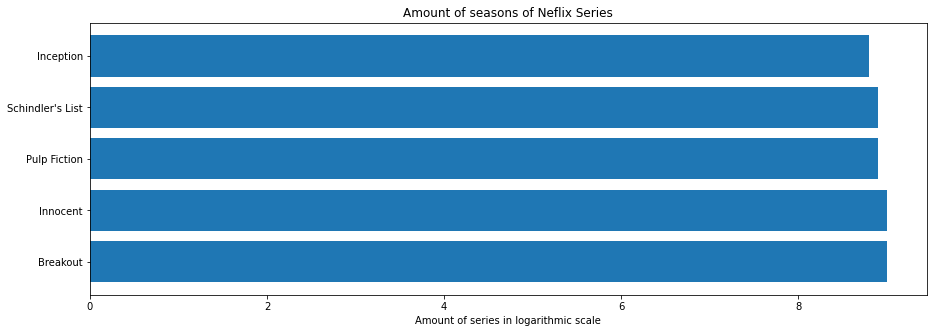

In [54]:
#First we merge the netflix movies and the IMDb movies to find which netflix movies are on the IMDb 
df3 = df.merge( movies_df, how='inner', left_on='title', right_on='title')

#Now we merge these movies with their ratings from IMDb
df4 = df3.merge(ratings_df, how='inner', left_on='imdb_title_id', right_on='imdb_title_id')

#From the final dataframe we keep the movies titles and their weighted average votes
stat_df=df4[['title','weighted_average_vote']].dropna()

#We create a dictionary to store all the movies and order it to find the top ones
movNratings=dict()
for ind in stat_df.index:
  movNratings[stat_df['title'][ind]]=stat_df['weighted_average_vote'][ind]

new_dict=OrderedDict(sorted(movNratings.items(), key = itemgetter(1), reverse = True))
res=list(new_dict.items())[:5]

x=[]
y=[]

#Print in a bar plot the top 10 movies
for indx in res:
  x.append(indx[0])
  y.append(indx[1])
labels =x
sizes=y

fig = plt.figure(figsize=(15,5))
plt.barh(labels, sizes)
#plt.xscale('log')
plt.xlabel("Amount of series in logarithmic scale")
plt.title('Amount of seasons of Neflix Series')
plt.show()

Βλέποντας τι λάτρεψαν κυριολεκτικά σχεδόν όλοι οι χρήστες, μπορεί να οδηγήσει σε αποφάσεις παραγωγής με στόχο την βέλτιστη ικανοποίηση του χρήστη, αναπαράγωντας συστήματα και ιδέες από παραγωγές που είχαν εξαιρετική απόδοση.

---
# <center>Recommendation System</center>
---

<center><h2>Preprocessing:</h2></center>

In [55]:
# A function that given a dataframe and a column name, returns all the data on the column as a single string
def col_to_text(datFr, movieId, colName):
  return list(datFr[colName][ datFr['show_id']==movieId ])[0]
#col_to_text(df, 's7785', 'description')

In [56]:
# A function that processes the given string and removes unwanted characters
def preprocess(text):
  words = nltk.sent_tokenize(text)
  for i in range(len(words)):
    words[i] = words[i].lower()
    words[i] = re.sub("[^a-zA-Z]", " ", str(words[i]))
    words[i] = re.sub(r'\W', ' ', words[i])
    words[i] = re.sub(r'\s+', ' ', words[i])
  return words 

In [57]:
# A function that returns a list of all the movie ids and titles 
def getMovies(df):
  mylist=[]
  movies = df[['show_id','title']][df['type']=='Movie']
  for element in movies.index:
    movies['title'][element]=movies['title'][element].encode("ascii","ignore")
    movies['title'][element] = movies['title'][element].decode()
    mylist.append((movies['show_id'][element],movies['title'][element]))
  return mylist
#getMovies(df)

In [58]:
# Get the id of all the movies
movies = getMovies(df)

# Store the text from each movie's description on a dictionary after a bit of clean up
text_dict = dict()
for movie in movies:
  text = col_to_text(df, movie[0], 'description')
  text_dict[movie] = preprocess(text)

text_list = []
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
for entry in text_dict:
  temp_list=re.sub("[^\w]", " ",  str(text_dict[entry])).split()
  filtered = [w for w in temp_list if not w in stop_words]
  stem_list=[]
  for i in filtered:
    stem_list.append(ps.stem(i))
  text_dict[entry]=" ".join(stem_list)
  text_list.append(text_dict[entry])
  #print(text_dict[entry])

In [59]:
# Define the amount of features that will be used and [min_dif, max_df]
features = 1000
midf = 1
madf = 1.0

# Create a dictionary that associates every movie name with an index in the "trained" vectorisers
# to be able to know which row is which later
# (shared between both unigram and bigram datasets since they are indexed in the same way)
indexOf = dict()
for i, movie in enumerate(text_dict):
  indexOf[movie[1]] = i
# Also its "reverse" dictionary to find movie names from indexes
nameOf = dict()
for i, movie in enumerate(text_dict):
  nameOf[i] = movie[1]

Σημείωση: Όσον αφορά τα representations που χρησιμοποιήσαμε, ξεκινήσαμε κάνοντας πειράματα με δύο διαφορετικά representations για κάθε μέθοδο. (Μια μόνο με unigrams και μια με bigrams αντίστοιχα για BoW και για TF-IDF) Συγκρίνοντας τα αποτελέσματά τους στο ερώτημα 3, παρατηρήσαμε ότι τα bigrams απο μόνα τους δεν είχαν ιδιαίτερα καλή απόδοση (Λογικό αυτό λόγω του σχετικά μικρού μεγέθους των δεδομένων που χειριζόμαστε), καθώς πολύ σπάνια υπάρχει αντιστοιχία bigrams μεταξύ descriptions γεγονός που μειώνει την απόδοση και την αξιοπιστια της μεθόδου σε κάποιο βαθμό). <br/><br/>
Τα unigrams, όπως αναμέναμε λειτούργησαν αρκετά καλύτερα αλλά και πάλι με σχετικά μικρά ποσοστά ομοιότητας. <br/><br/>
Τελικά, η αναπαράσταση με την οποία επιτύχαμε την καλύτερη ακρίβεια μετά από πειράματα και έλεγχο των descriptions των αποτελεσμάτων, ήταν ένας συνδυασμός των δύο μεθόδων. Βάζοντας τόσο τα unigrams, όσο και τα bigrams στην ίδια αναπαράσταση, η χρήση unigrams "καλύπτει" την αδυναμία των bigrams (την σπανιοτητα τους), ενώ τα bigrams δίνουν μεγαλύτερο βάρος σε απαντήσεις-αποτελέσματα με πιο ομοια σύνταξη και παρόμοιες ακολουθίες λέξεων, που συνήθως έχουν και παρόμοιο νόημα. Συνεπώς, οι αναπαραστάσεις που θα δείτε απο κάτω, μια για BoW και μια για TF-IDF είναι υλοποιημένες με συνδυασμό unigrams και bigrams, με βάση την παραπάνω λογική, με στόχο να πετύχουμε όσο καλύτερη ακρίβεια μπορούμε στα αποτελέσματά μας.

---
# <center> <h2>Boolean BoW</h2> </center>

In [60]:
# Create the required vectorizers for both unigrams and bigrams (while not counting stopwords)
bow_u_vectorizer = CountVectorizer(ngram_range = (1,2), max_df=madf, min_df=midf, max_features=features, stop_words='english')

# "Train" the vectorizers (Turn the result to bool for boolean BoW)
bow_u_trained = bow_u_vectorizer.fit_transform(text_list).astype('bool')

---
# <center> <h2>TF-IDF</h2> </center>

In [61]:
# Create the required vectorizers for both unigrams and bigrams (while not counting stopwords)
tfidf_u_vectorizer = TfidfVectorizer(ngram_range = (1,2), max_df=madf, min_df=midf, max_features=features, stop_words='english')

# "Train" the vectorizers 
tfidf_u_trained = tfidf_u_vectorizer.fit_transform(text_list)

---
# <center> <h2>Similarity calculation</h2> </center> 

In [93]:
# Calculate the Jacard similarities of all the records on the given array
# Results on a NxN symmertic table
# We used this custom function for better performance
def jaccard(X, Y=None):
  if Y is None:
    Y = X

  # Convert the types to suit our needs
  X = X.astype(bool).astype(int)
  Y = Y.astype(bool).astype(int)

  # Intersect the two tables and use matrix transformations to calculate the jaccard scores 
  intersect = X.dot(Y.T)
  x_sum = X.sum(axis=1).A1
  y_sum = Y.sum(axis=1).A1
  xx, yy = np.meshgrid(x_sum, y_sum)
  union = ((xx + yy).T - intersect)
  return ( intersect / union).A

In [94]:
# Using both the custom jacard function and the built in sklearn function, calculate the similarities
bow_uni = jaccard(bow_u_trained)
tfidf_uni_array = cosine_similarity(tfidf_u_trained)

In [95]:
# A function that returns the correct similarity data array for each occation
def get_data(entry, method):
  if method == 'boolean':
    return bow_uni[indexOf[entry]]
  else:
      return tfidf_uni_array[indexOf[entry]]

In [96]:
# Converts a list to a dic using our indexing system
def list_to_dict(lst, ignore):
  trg = dict()
  for i, rec in enumerate(lst):
    if i == indexOf[ignore]:
      continue
    trg[nameOf[i]] = rec
  return trg

In [97]:
# A function that given a movie and a similarity dictionary, returns a list of the top N most similar movies
def get_similar_movies1(entry, N=10, method='boolean'):
  # Based on the given arguments, decide which similarity data we will use
  sim_d = get_data(entry, method)

  # Turn the list of values into a dictionary to heapify later 
  # while ignoring the target entry
  dic = list_to_dict(sim_d, entry)
  
  # Using a heap for better complexities, we pass through all the similarity scores
  # and keep the N higher ones
  return heapq.nlargest(N, dic.items(), key=lambda x: x[1])

In [69]:
# Now for each movie, save the 100 most similar movies on the list based on the results
N = 100
topNjac_uni = dict()
topNcos_uni = dict()
for entry in text_dict.keys():
  topNjac_uni[entry] = get_similar_movies1(entry[1], N, method='boolean')
  topNcos_uni[entry] = get_similar_movies1(entry[1], N, method='cosine')

---
# <center> <h2>Prediction 1</h2> </center> 

In [98]:
# A function to print the results of get_similar_movies1 as text
def print_res(res):
  #print("> Printing most similar movies for the given movie:\n")
  print("    Similarity  |    Movie    ")
  print("--------------------------------")
  for tup in res:
    print("      %.2f %%   |  %s" % (tup[1]*100, tup[0]))

In [99]:
# A function to plot the results returnes from get_similar_movies1
def plot_res(res):
  tags = []
  vals = []
  for tup in res:
    tags.append(tup[0])
    vals.append(tup[1])

  fig = plt.figure(figsize=(15,5))
  plt.barh(tags, vals)
  plt.xlabel('Similarity percentage')
  plt.ylabel('Movies')
  plt.title('Most similar movies')
  plt.show()

Δοκιμαστικά, κάνουμε μια πρόβλεψη με κάθε μέθοδο για την ίδια ταινία για να συγκρίνουμε τις μεθόδους:

In [100]:
# The movie we will use for testing
test_movie = 'Wish Man'
print(" < Similar movies to %s >" % test_movie)

# BoW
print("\n(i) Using BoW")
print_res(get_similar_movies1(test_movie, N=10, method='boolean'))

# Tfidf
print("\n(i) Using Tfidf")
print_res(get_similar_movies1(test_movie, N=10, method='cosine'))

 < Similar movies to Wish Man >

(i) Using BoW
    Similarity  |    Movie    
--------------------------------
      33.33 %   |  The Sky Is Pink
      28.00 %   |  Notes for My Son
      26.09 %   |  Walk. Ride. Rodeo.
      24.00 %   |  Zodiac
      23.08 %   |  Saawan
      22.73 %   |  93 Days
      22.73 %   |  The Command
      21.74 %   |  The Conjuring
      20.83 %   |  Adrift
      20.83 %   |  Gabriel and the Mountain

(i) Using Tfidf
    Similarity  |    Movie    
--------------------------------
      56.42 %   |  The Sky Is Pink
      44.19 %   |  Notes for My Son
      39.93 %   |  Walk. Ride. Rodeo.
      37.01 %   |  93 Days
      36.82 %   |  Adrift
      36.74 %   |  Zodiac
      36.06 %   |  Saawan
      35.86 %   |  The Command
      34.68 %   |  Extremely Wicked, Shockingly Evil and Vile
      34.38 %   |  Loving


Βλέποντας την σύγκριση των δύο μεθόδων, η παρόλο που οι δύο μέθοδοι βγάζουν παρόμοιες "προτάσεις" ώς αποτελέσματα, παρατηρούμε πως η TF-IDF επιτυγχάνει σημαντικά μεγαλύτερα "ποσοστά ομοιότητας" από την BoW. Μετά από ελέγχους των descriptions από εμάς, όντως η TF-IDF φαίνεται να επιστρέφει πιο ακριβή αποτελέσματα από την BoW τουλάχιστον στα test cases μας(λογικό με βάση τον τρόπο λειτουργίας της κάθε μεθόδου)

---
# <center> <h2>Prediction 2</h2> </center> 

In [73]:
#These functions compute the most similar movies based on a description
def work1(descr,N,vect,trained):
  vect = vect.fit(text_list)                      #first we fit the text list in order yo transform the description based on it
  newq = vect.transform([descr]).astype('bool')
  new_cos = jaccard(newq, trained).flatten()      #now we use the jaccard function to find the movies that match to it
  sims = jaccard(newq, trained)[0]
  related_movies_vals = new_cos.argsort()[-N:][::-1]    #get top N similar movies
  
  top = []
  for index in related_movies_vals:
    top.append( (nameOf[index], sims[index]) )
  return top

#same as above but for tfidf, works with cosine similarity instead of jaccard
def work2(descr,N,vect,trained):
  vect = vect.fit(text_list)
  newq = vect.transform([descr])
  new_cos = cosine_similarity(newq, trained).flatten()
  sims = cosine_similarity(newq, trained)[0]
  related_movies_vals = new_cos.argsort()[-N:][::-1]
  top = []
  for index in related_movies_vals:
    top.append( (nameOf[index], sims[index]) )
  return top

#fucntion that calls the above two functions based on the parameters given by the user
def get_similar_movies2(descr,N,method):
  if method == 'boolean':
     return work1(descr,N,bow_u_vectorizer,bow_u_trained)
  else:
    return work2(descr,N,tfidf_u_vectorizer,tfidf_u_trained)

In [82]:
# A function to print the results of get_similar_movies1 as text
def print_res2(res):
  #print("> Printing most similar movies for the given movie:\n")
  print("    Similarity  |    Movie    ")
  print("--------------------------------")
  for tup in res:
    print("      %.2f %%   |  %s" % (tup[1]*100, tup[0]))

Όπως και παραπάνω, κάνουμε μια πρόβλεψη με κάθε μέθοδο για την ίδια ταινία για να συγκρίνουμε τις μεθόδους:

In [83]:
# The movie we will use for testing
test_description = 'college american pie sex party'
print(" < Similar movies to %s >" % test_description)

# BoW
print("\n(i) Using BoW")
print_res2(get_similar_movies2(test_description, N=10, method='boolean'))

# Tfidf
print("\n(i) Using Tfidf")
print_res2(get_similar_movies2(test_description, N=10, method='cosine'))

 < Similar movies to college american pie sex party >

(i) Using BoW
    Similarity  |    Movie    
--------------------------------
      22.22 %   |  Katt Williams: Great America
      20.00 %   |  Nikki Glaser: Bangin
      18.18 %   |  I Am Jane Doe
      16.67 %   |  Heneral Luna
      16.67 %   |  The Ballad of Buster Scruggs
      16.67 %   |  The Runner
      16.67 %   |  Malena Pichot: Estupidez compleja
      16.67 %   |  Ricardo Quevedo: Hay gente as
      16.67 %   |  Louis C.K.: Live at the Comedy Store
      16.67 %   |  David Cross: Making America Great Again!

(i) Using Tfidf
    Similarity  |    Movie    
--------------------------------
      42.39 %   |  Katt Williams: Great America
      40.93 %   |  I Am Jane Doe
      38.90 %   |  Nikki Glaser: Bangin
      37.01 %   |  Mohawk
      34.13 %   |  Ricardo Quevedo: Hay gente as
      33.51 %   |  The Runner
      33.31 %   |  Malena Pichot: Estupidez compleja
      31.47 %   |  Sam Kinison: Breaking the Rules
      3

Όπως και στο ερώτημα 3, και εδώ τόσο από τα ποσοστά ομοιότητας των μεθόδων, όσο και από τους δικούς μας ελέγχους, η TF-IDF φαίνεται να αποφέρει λίγο καλύτερα αποτελέσματα, παρόλο που οι δύο μέθοδοι προτείνουν σχεδόν τις ίδιες επιλογές με λίγο διαφορετική σειρά.


<center> <h2> Πιθανοί λόγοι Αστοχίας Αποτελεσμάτων: </h2> </center>

Τα αποτελέσματα που βρίσκουμε μπορεί να μην είναι πάντα καλά/ακριβή για έναν ή περισσότερους από τους παρακάτω λόγους:

1) **Μέγεθος των δεδομένων που διαθέτουμε**: Τα descriptions που έχουμε είναι πολύ μικρά με αποτέλεσμα να μην μπορούμε να δημιουργήσουμε μια ακριβή - αρκετά αντιπροσωπευτική αναπαράσταση για αυτά. <br/><br/>
2) **Οι μέθοδοι που χρησιμοποιούμε**: Τα representations που χρησιμοποιούμε βασίζονται αποκλειστικά σε έναν παράγοντα για να λάβουν την απόφασή τους, το λεξιλόγιο των descriptions. Χρησιμοποιώντας representations τα οποία λαμβάνουν αποφάσεις με βάση συνδυασμούς μετρικών με βάρύτητες, [πχ w1 x (λεξιλόγιο description) + w2 x (tags κατηγορίας ταινίας) + w3 x (ενδιαφέροντα χρήστη με βάση ιστορικό) + w4 x (ηλικία χρήστη vs  ηλικιακές ομάδες που απευθύνεται η ταινία/σειρα) ... ]. Βέβαια, πολυπαραγωντικές μέθοδοι είναι πολύ πιο πολύπλοκες στην υλοποίηση και απαιτούν αρκετό πειραματισμό.<br/><br/>


<center> <h2> Τελικά Συμπεράσματα-Ιδέες: </h2> </center>

1) Σε γενικές γραμμές, μπορεί τα αποτελέσματα να μην είναι τα πιο ακριβή, αλλα είναι εντυπωσιακά usable για την απλότητα με την οποία δημιουργήθηκαν και για τόσο λίγα δεδομένα-μικρά descriptions. Πιο πολύπλοκες μέθοδοι με πολύ περισσότερα δεδομένα και μετρικές όπως βλέπουμε καθημερινά μπορούν να αποφέρουν εξαιρετικά αποτελέσματα, αλλά οι δοκιμές που κάναμε είναι μια ενδιαφέρουσα εισαγωγη στα big data και στο data mining.

2) Mια ιδέα για μια μικρή βελτίωση της ακρίβειας των προβλέψεων θα ήταν να συνδυάζουμε με κάποιο τρόπο<br/>(πχ μέσο όρο) τα αποτελέσματα των δύο μεθόδων για επίτευξη μεγαλύτερης ομοιότητας, ή ακόμα και την χρήση των αξιολογήσεων της κάθε ταινίας, ώστε να δίνουμε μεγαλύτερο βάρος σε ταινίες με πολύ καλές κριτικές και να "υποβαθμίζουμε" σε κάποιο βαθμό με πολύ ασχημες κριτικές. 
